# Results Analysis - Use Features and Similarity Measure 

In [1]:
import os
import glob
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.chdir('../')

In [2]:
from scipy.signal import argrelmin, argrelmax

In [3]:
from dap import DAPcython
from dap.utils import obs_params, load_current
from tqdm import tqdm
from scipy.spatial import distance

### Set Parameters

In [4]:
dt = 1e-2
params, labels = obs_params(reduced_model=False)
data_dir = '/home/alteska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'

### load the file

In [5]:
df_param = pd.read_csv('dap_models_4_param_1x20.csv')
df_param.head()

,Unnamed: 0,gbar_nap,gbar_leak,gbar_nat,gbar_kdr
0,1x14,17.173732,1.074666,131.422942,3.410514
1,1x35,17.097219,1.039869,117.684230,3.737484
2,1x9,19.007380,0.991425,95.365731,2.976070
3,1x19,16.370543,1.028504,141.774573,3.430032
4,1x24,15.153335,1.100184,163.721094,3.055541


### calculate DAP

In [6]:
# load the input data
Ir, vr, tr, t_onr, t_offr, dtr = load_current(data_dir, protocol='rampIV', ramp_amp=3.1)
Is, vs, ts, t_ons, t_offs, dts = load_current(data_dir, protocol='IV', ramp_amp=1)

# define a model
dap = DAPcython(-75, params)

In [7]:
# run models on original parameters
U_step = dap.simulate(dts, ts, Is)
U_ramp = dap.simulate(dtr, tr, Ir)

### calculate the similarities

In [8]:
d_step = distance.euclidean(vs, U_step)
d_step

2646.0371625853236

In [9]:
d_ramp = distance.euclidean(vr, U_ramp)
d_ramp

476.7954272430242

In [10]:
d_step+d_ramp

3122.832589828348

### run for all cells and save into the the DF

In [11]:
df_paramT = df_param.transpose()
df_paramT.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
Unnamed: 0,1x14,1x35,1x9,1x19,1x24,1x16,1x31k,1x12,1x27,1x23,...,1x29,1x32,1x38,1x25,1x22,1x33,1x11k,1x21k,1x34,1x17
gbar_nap,17.1737,17.0972,19.0074,16.3705,15.1533,16.5159,14.3871,16.1834,16.5867,18.9342,...,17.6876,16.3393,15.0246,16.75,15.3665,18.0509,19.5432,16.0778,16.4121,16.1261
gbar_leak,1.07467,1.03987,0.991425,1.0285,1.10018,1.12175,1.09387,1.03587,1.04691,1.02568,...,1.0718,0.990389,1.09574,1.12461,1.03158,1.07151,1.08542,0.998721,1.04461,1.05032
gbar_nat,131.423,117.684,95.3657,141.775,163.721,120.139,164.15,108.917,169.626,115.465,...,95.5836,153.131,178.05,118.797,166.835,113.727,125.533,141.34,160.322,115.381
gbar_kdr,3.41051,3.73748,2.97607,3.43003,3.05554,3.41498,3.12817,2.99428,3.17433,3.19455,...,3.4647,3.13496,3.20731,3.08609,3.10394,3.78725,3.16457,3.84604,3.10372,3.33547


In [12]:
df_paramT.drop('Unnamed: 0', inplace=True)
df_paramT.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
gbar_nap,17.1737,17.0972,19.0074,16.3705,15.1533,16.5159,14.3871,16.1834,16.5867,18.9342,...,17.6876,16.3393,15.0246,16.75,15.3665,18.0509,19.5432,16.0778,16.4121,16.1261
gbar_leak,1.07467,1.03987,0.991425,1.0285,1.10018,1.12175,1.09387,1.03587,1.04691,1.02568,...,1.0718,0.990389,1.09574,1.12461,1.03158,1.07151,1.08542,0.998721,1.04461,1.05032
gbar_nat,131.423,117.684,95.3657,141.775,163.721,120.139,164.15,108.917,169.626,115.465,...,95.5836,153.131,178.05,118.797,166.835,113.727,125.533,141.34,160.322,115.381
gbar_kdr,3.41051,3.73748,2.97607,3.43003,3.05554,3.41498,3.12817,2.99428,3.17433,3.19455,...,3.4647,3.13496,3.20731,3.08609,3.10394,3.78725,3.16457,3.84604,3.10372,3.33547


In [13]:
daps = []
U_steps = []
U_ramps = []

for i, j in tqdm(df_paramT.iterrows()):
    # get parameters
    par_temp = j.values

    # define a model
    daps.append(DAPcython(-75, j))

    # run model
    U_steps.append(dap.simulate(dts, ts, Is).transpose()[0])
    U_ramps.append(dap.simulate(dtr, tr, Ir).transpose()[0])

4it [00:04,  1.14s/it]


### Create DF with traces

In [14]:
df_arr = pd.DataFrame({'traces': U_steps})
df_arr.set_index(df_paramT.index.values, inplace=True)
df_arr.head()

,traces
gbar_nap,"[-75.00977393405479, -74.9869928784786, -75.00..."
gbar_leak,"[-75.00388365542915, -74.98327190776246, -74.9..."
gbar_nat,"[-75.00402659104509, -75.00308326502359, -74.9..."
gbar_kdr,"[-75.00875699044965, -74.98342996539165, -74.9..."


In [15]:
result = pd.merge(
    df_paramT,
    df_arr,
    how='left',
    left_index=True, # Merge on both indexes, since right only has 0...
    right_index=True # all the other rows will be NaN
)

result

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,traces
gbar_nap,17.1737,17.0972,19.0074,16.3705,15.1533,16.5159,14.3871,16.1834,16.5867,18.9342,...,16.3393,15.0246,16.75,15.3665,18.0509,19.5432,16.0778,16.4121,16.1261,"[-75.00977393405479, -74.9869928784786, -75.00..."
gbar_leak,1.07467,1.03987,0.991425,1.0285,1.10018,1.12175,1.09387,1.03587,1.04691,1.02568,...,0.990389,1.09574,1.12461,1.03158,1.07151,1.08542,0.998721,1.04461,1.05032,"[-75.00388365542915, -74.98327190776246, -74.9..."
gbar_nat,131.423,117.684,95.3657,141.775,163.721,120.139,164.15,108.917,169.626,115.465,...,153.131,178.05,118.797,166.835,113.727,125.533,141.34,160.322,115.381,"[-75.00402659104509, -75.00308326502359, -74.9..."
gbar_kdr,3.41051,3.73748,2.97607,3.43003,3.05554,3.41498,3.12817,2.99428,3.17433,3.19455,...,3.13496,3.20731,3.08609,3.10394,3.78725,3.16457,3.84604,3.10372,3.33547,"[-75.00875699044965, -74.98342996539165, -74.9..."


In [16]:
result2 = pd.merge(
    result,
    df_arr,
    how='left',
    left_index=True, # Merge on both indexes, since right only has 0...
    right_index=True # all the other rows will be NaN
)

result2

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,traces_x,traces_y
gbar_nap,17.1737,17.0972,19.0074,16.3705,15.1533,16.5159,14.3871,16.1834,16.5867,18.9342,...,15.0246,16.75,15.3665,18.0509,19.5432,16.0778,16.4121,16.1261,"[-75.00977393405479, -74.9869928784786, -75.00...","[-75.00977393405479, -74.9869928784786, -75.00..."
gbar_leak,1.07467,1.03987,0.991425,1.0285,1.10018,1.12175,1.09387,1.03587,1.04691,1.02568,...,1.09574,1.12461,1.03158,1.07151,1.08542,0.998721,1.04461,1.05032,"[-75.00388365542915, -74.98327190776246, -74.9...","[-75.00388365542915, -74.98327190776246, -74.9..."
gbar_nat,131.423,117.684,95.3657,141.775,163.721,120.139,164.15,108.917,169.626,115.465,...,178.05,118.797,166.835,113.727,125.533,141.34,160.322,115.381,"[-75.00402659104509, -75.00308326502359, -74.9...","[-75.00402659104509, -75.00308326502359, -74.9..."
gbar_kdr,3.41051,3.73748,2.97607,3.43003,3.05554,3.41498,3.12817,2.99428,3.17433,3.19455,...,3.20731,3.08609,3.10394,3.78725,3.16457,3.84604,3.10372,3.33547,"[-75.00875699044965, -74.98342996539165, -74.9...","[-75.00875699044965, -74.98342996539165, -74.9..."


## Specify the Features Function 

In [17]:
def find_spikes(v):
    # look for non-resting potential values
    ind = np.where(v < -10)
    v[ind] = -10
    ind = np.where(np.diff(v) < 0)
    v[ind] = -10

    # look for all slope changes
    v = (np.diff(v) > 0).astype(int)

    # get all change of slopes indices
    v_ind = np.where(np.diff(np.sign(v)))[0]
    
    # return last positive change of slope 
    return v_ind[1::2]


In [18]:
def calc_features_step(U, t, dt, t_on, t_off):
    v = U.copy()
    N = v.shape[0]

    # resting potential
    rest_pot = np.mean(v[t<t_on])
    rest_pot_std = np.std(v[int(.9*t_on/dt):int(t_on/dt)])  
 
    ind = find_spikes(v)

    spike_times = np.array(t)[ind]
    spike_times_stim = spike_times[(spike_times > t_on)  & (spike_times < t_off)]
    ind_stim1 = ind[(spike_times > t_on) & (spike_times < t_off)]
    ind_stim = ind_stim1.astype(int)

    firing_rate = 1e3*np.absolute(spike_times_stim.shape[0]/(t_off-t_on))
    time_1st_spike = spike_times_stim[spike_times_stim>t_on][0]

    ISI = np.diff(spike_times_stim).astype(float)

    
    sum_stats_vec = np.array([
                rest_pot,
                rest_pot_std,
                len(spike_times_stim),
                spike_times_stim,
                firing_rate,
                ISI.mean(),
                ISI.std()
                ])


    return sum_stats_vec

In [19]:
# def flatten(U):
#     v = U.copy()
#     ind = np.where(v < -10)
#     v[ind] = -10
#     ind = np.where(np.diff(v) < 0)
#     v[ind] = -10
    
#     return v

### Ramp Current

In [20]:
def calc_ramp_sum_stats(v, t, dt, t_on, t_off):
    """Calculate summary statistics of a single run with ramp current(single spike with DAP)"""
    stats = []
    stats_idx = []
#     v = v.transpose()
    N = v.shape[0]

    # resting potential
    rest_pot = np.mean(v[t<t_on])
    rest_pot_std = np.std(v[int(.9*t_on/dt):int(t_on/dt)])   # TODO: add if needed

    # RMSE
#     n = len(self.v0)
#     rmse = np.linalg.norm(v - self.v0) / np.sqrt(n)

    # more then one AP:
    multiple_AP = np.shape(np.where(v > 0))[1]

    #case without any action potential or more then one AP
    if (np.all(v <= 20)):
        AP_onsets = 999
        AP_amp = 999
        AP_width = 999
        DAP_amp = 999
        DAP_width = 999
        DAP_deflection = 999
        DAP_time = 999
        mAHP = 999
        fAHP = 999

    else:
        threshold = -30
        # hyperpolarization after DAP
        mAHP_idx = np.argmin(v)
        mAHP = v[mAHP_idx]

        # Action potential
        AP_onsets = np.where(v > threshold)[0]
        AP_start = AP_onsets[0]
        AP_end = AP_onsets[-1]
        AP_max_idx = AP_start + np.argmax(v[AP_start:AP_end])
        AP_max = v[AP_max_idx]
        AP_amp = AP_max - rest_pot

        # AP width
        AP_onsets_half_max = np.where(v > (AP_max+rest_pot)/2)[0]
        AP_width = t[AP_onsets_half_max[-1]] - t[AP_onsets_half_max[0]]

        # DAP: fAHP
        v_dap = v[AP_max_idx:]

        fAHP_idx = argrelmin(v[AP_max_idx:])[0][0] + AP_max_idx
        fAHP = v[fAHP_idx]

        # DAP amplitude
        DAP_max_idx = argrelmax(v_dap)[0][1] + AP_max_idx
        DAP_max = v[DAP_max_idx]
        DAP_amp = DAP_max - rest_pot

        DAP_deflection = DAP_amp - (fAHP - rest_pot)
        DAP_time = t[DAP_max_idx] - t[AP_max_idx]    # Time between AP and DAP maximum

        # Width of DAP: between fAHP and halfsize of fAHP after DAP max
        vnorm = v[DAP_max_idx:] - rest_pot

        if np.any((abs(vnorm) < abs(fAHP - rest_pot)/2)):
            half_max = np.where((abs(vnorm) < abs(fAHP - rest_pot)/2))[0]

            DAP_width_idx = DAP_max_idx + half_max[0]
            DAP_width = (DAP_width_idx - fAHP_idx) * dt
        else:
            DAP_width = 999


    sum_stats_vec = np.array([
                    rest_pot,
                    AP_amp,
                    AP_width,
                    fAHP,
                    DAP_amp,
                    DAP_width,
                    DAP_deflection,
                    DAP_time,
                    mAHP,
                    ])


    return sum_stats_vec

### Test Summary Stats

In [21]:
U_steps[0].transpose()

array([-75.00977393, -74.98699288, -75.00375347, ..., -75.2063635 ,
       -75.19943932, -75.18236454])

In [22]:
x0 = calc_features_step(U_steps[0].transpose(), ts, dts, t_ons, t_offs)
x0

array([-75.22648746203174, 0.037003456735133534, 47,
       array([253.4 , 253.5 , 262.6 , 274.7 , 287.8 , 301.  , 314.3 , 314.4 ,
       327.55, 327.65, 340.75, 354.  , 367.4 , 380.75, 394.1 , 407.5 ,
       420.9 , 434.4 , 447.85, 461.25, 474.65, 488.  , 501.45, 514.8 ,
       528.2 , 541.6 , 541.7 , 554.9 , 568.25, 581.65, 595.05, 595.15,
       608.4 , 608.5 , 621.7 , 635.1 , 648.5 , 661.9 , 675.25, 688.65,
       702.05, 702.15, 715.35, 715.45, 728.7 , 742.1 , 742.2 ]),
       94.0, 10.62608695652174, 5.231070834866906], dtype=object)

In [23]:
vs

array([-76.625  , -76.5625 , -76.625  , ..., -77.5    , -77.53125,
       -77.53125])

In [24]:
step_features_labels = ['rest_pot', 'rest_pot_std', 'spike_count', 'spike_times_stim','firing_rate', 'ISI_mean', 'ISI_std']

In [25]:
x_orig = calc_features_step(vs.transpose(), ts, dts, t_ons, t_offs)
pd.DataFrame(data=x_orig, index=step_features_labels)

,0
rest_pot,-76.6336
rest_pot_std,0.0635106
spike_count,24
spike_times_stim,"[254.6, 258.40000000000003, 264.6, 275.9500000..."
firing_rate,48
ISI_mean,20.6217
ISI_std,6.0668


In [26]:
ramp_features_labels = ['rest_pot', 'AP_amp', 'AP_width', 'fAHP', 'DAP_amp', 'DAP_width', 'DAP_deflection','DAP_time', 'mAHP']

In [27]:
sim = calc_ramp_sum_stats(U_ramps[0], tr, dtr, t_onr, t_offr)
pd.DataFrame(data=sim, index=ramp_features_labels)

,0
rest_pot,-75.018015
AP_amp,130.966498
AP_width,0.750000
fAHP,-64.283568
DAP_amp,10.516858
DAP_width,22.520000
DAP_deflection,-0.217589
DAP_time,2.310000
mAHP,-77.602052


In [28]:
U_ramps[0]

array([-75.00706421, -74.99506302, -74.99686386, ..., -75.12313775,
       -75.15006593, -75.16443504])

### Vizualize found spikes

In [29]:
t = find_spikes(vs)
x = np.zeros_like(t)

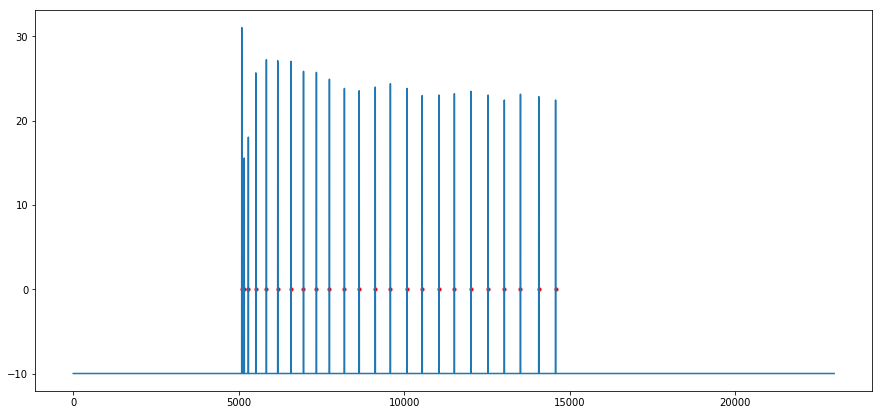

In [30]:
plt.figure(figsize=(15,7))
plt.scatter(t, x, c='r', s=10);
plt.plot(vs);